In [1]:
import logging
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

# Using SciPy.cluster for clustering
from scipy.cluster import hierarchy
from scipy.cluster import vq

# Using Scikit Learn for clustering
#from sklearn.cluster import KMeans
import sklearn.cluster as skc
from sklearn import metrics

import FINE.spagat.utils as spu
import FINE.spagat.dataset as spd

import FINE.spagat.grouping_utils as gu  
#from ipynb.fs.full import grouping_utils 

## test dataset - (test_dataset2)

In [2]:
space = ['01_reg','02_reg','03_reg']
TimeStep = ['T0','T1']
space_2 = space.copy()
component = ['c1','c2','c3','c4']
Period = [0]

demand = np.stack([[[[np.nan,np.nan, np.nan] for i in range(2)]],
                        [[[1, 0.9,  2],
                          [1, 0,  0.9]]],
                        [[[np.nan,np.nan, np.nan] for i in range(2)]],
                        [[[0,   1, 1],
                          [0.3, 2, 1]]]])
demand = xr.DataArray(demand, coords=[component, Period, TimeStep, space], dims=['component', 'Period', 'TimeStep','space'])
cap_1d = np.stack([[0.9,  1,  0.9],
                        [0,    0,  0],
                        [0.9,  1,  0.9],
                        [np.nan] *3])
cap_1d = xr.DataArray(cap_1d, coords=[component,space], dims=['component','space'])
dist_2d = np.stack([[[0,1,2],[1,0,10],[2,10,0]],
                         [[0,0.1,0.2],[0.1,0,1],[0.2,1,0]],
                         [[np.nan] * 3 for i in range(3)],
                         [[np.nan] * 3 for i in range(3)]])
dist_2d = xr.DataArray(dist_2d, coords=[component,space,space_2], dims=['component','space','space_2'])

ds = xr.Dataset({'operationFixRate': demand, '1d_capacity': cap_1d, '2d_distance': dist_2d})

sds = spd.SpagatDataset()
sds.xr_dataset = ds

sds.xr_dataset

<xarray.Dataset>
Dimensions:           (Period: 1, TimeStep: 2, component: 4, space: 3, space_2: 3)
Coordinates:
  * component         (component) <U2 'c1' 'c2' 'c3' 'c4'
  * Period            (Period) int32 0
  * TimeStep          (TimeStep) <U2 'T0' 'T1'
  * space             (space) <U6 '01_reg' '02_reg' '03_reg'
  * space_2           (space_2) <U6 '01_reg' '02_reg' '03_reg'
Data variables:
    operationFixRate  (component, Period, TimeStep, space) float64 nan ... 1.0
    1d_capacity       (component, space) float64 0.9 1.0 0.9 0.0 ... nan nan nan
    2d_distance       (component, space, space_2) float64 0.0 1.0 ... nan nan

# all_variable_based_clustering()

In [27]:
verbose=False
ax_illustration=None 
save_fig='test' 
dimension_description='space' 
weighting=None

In [28]:
# Original region list
regions_list = sds.xr_dataset[dimension_description].values
n_regions = len(regions_list)

In [29]:
aggregation_dict = {}
aggregation_dict[n_regions] = {region_id: [region_id] for region_id in regions_list}
aggregation_dict

{3: {'01_reg': ['01_reg'], '02_reg': ['02_reg'], '03_reg': ['03_reg']}}

## Option 1.  agg_mode = 'hierarchical' 
#### Clustering method via SciPy.cluster module

In [30]:
agg_mode = 'hierarchical' 

In [31]:
#sds
handle_mode = 'toDissimilarity'
vars='all'
dims='all'
var_weightings=None

#### STEP 1.  Preprocess the whole dataset (grouping_utils - preprocessDataset())

In [32]:
# Obtain the data dictionaries for three var categories after preprocessing
dict_ts, dict_1d, dict_2d = gu.preprocessDataset(sds, handle_mode='toDissimilarity')

#### STEP 2.  Calculate the overall distance between each region pair (uses custom distance)

In [33]:
# Apply clustering methods based on the Custom Distance Function
squared_dist_matrix = gu.selfDistanceMatrix(dict_ts, dict_1d, dict_2d, n_regions)
squared_dist_matrix

array([[0.   , 4.845, 1.905],
       [4.845, 0.   , 2.755],
       [1.905, 2.755, 0.   ]])

#### STEP 3. Clustering

#### STEP 3a.  Hierarchical clustering with average linkage

In [34]:
distance_matrix = hierarchy.distance.squareform(squared_dist_matrix)
Z = hierarchy.linkage(distance_matrix, method='average')
Z

array([[0.   , 2.   , 1.905, 2.   ],
       [1.   , 3.   , 3.8  , 3.   ]])

In [35]:
print('The cophenetic correlation coefficient of the hiearchical clustering is ', hierarchy.cophenet(Z, distance_matrix)[0])
 

The cophenetic correlation coefficient of the hiearchical clustering is  0.7231402390092978


#### STEP 3b.  Figure for inconsistency check 

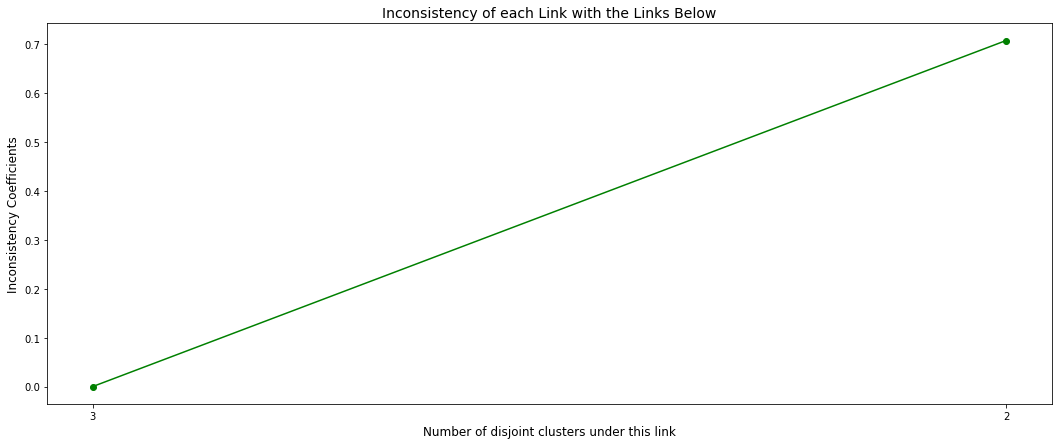

In [36]:
fig, ax = plt.subplots(figsize=(18,7))
inconsistency = hierarchy.inconsistent(Z)
ax.plot(range(1,len(Z)+1),list(inconsistency[:,3]),'go-')
ax.set_title('Inconsistency of each Link with the Links Below', fontsize=14)
ax.set_xlabel('Number of disjoint clusters under this link', fontsize=12)
ax.set_ylabel('Inconsistency Coefficients', fontsize=12)

plt.xticks(range(1,len(Z)+1), np.arange(len(Z)+1,1, -1))
plt.show()

#### STEP 3c.  If specified, figure for resulting dendrogram

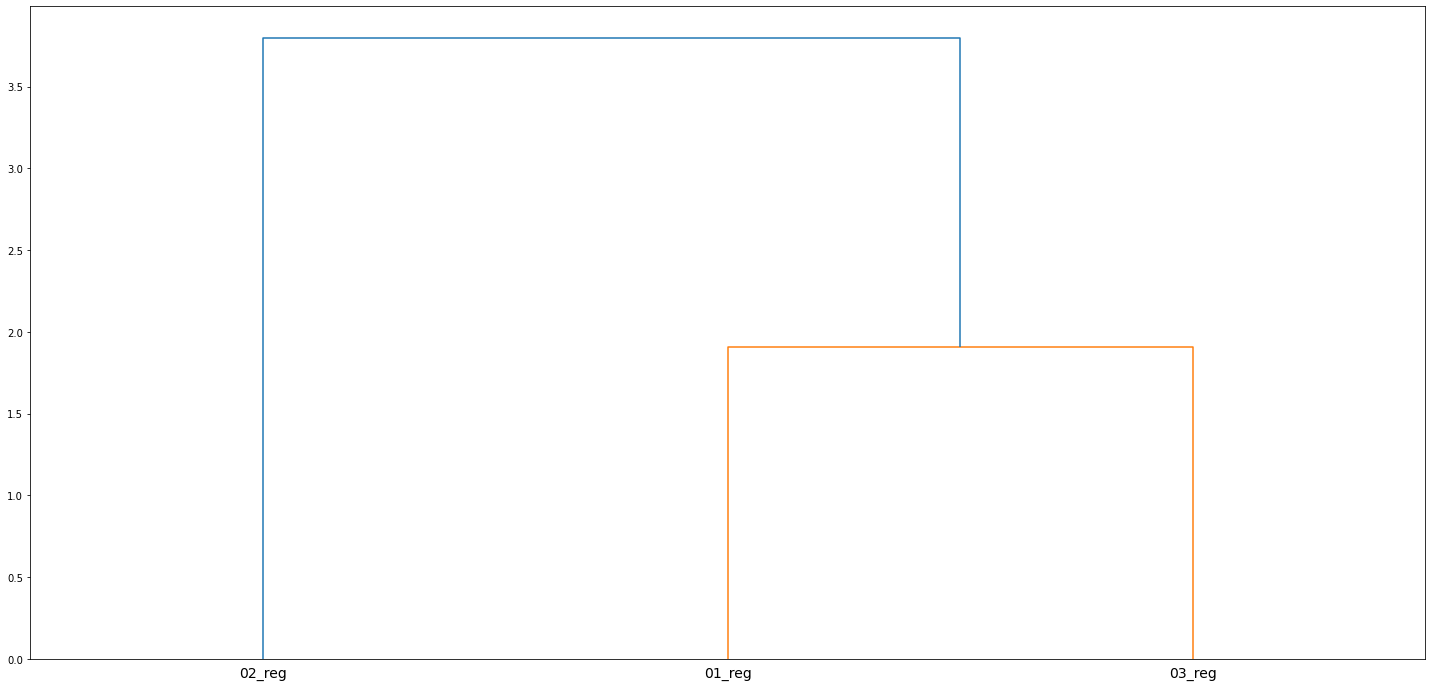

In [37]:

if ax_illustration is not None:
    R = hierarchy.dendrogram(Z, 
                          orientation="top",
                            labels=sds.xr_dataset[dimension_description].values, 
                            ax=ax_illustration, 
                            leaf_font_size=14
                            )

    if save_fig is not None:
        spu.plt_savefig(save_name=save_fig)

elif save_fig is not None:
    fig, ax = spu.plt.subplots(figsize=(25, 12))

    R = hierarchy.dendrogram(Z, 
                            orientation="top",
                            labels=sds.xr_dataset[dimension_description].values, 
                            ax=ax, 
                            leaf_font_size=14
                            )

    spu.plt_savefig(fig=fig, save_name=save_fig)
 

#### STEP 4.  find the sub_to_sup_region_id_dict for every level in the hierarchy

In [47]:
# regions_dict to record the newest region set after each merging step, regions_dict_complete for all regions appearing during clustering
regions_dict = {region_id: [region_id] for region_id in regions_list}
regions_dict

{'01_reg': ['01_reg'], '02_reg': ['02_reg'], '03_reg': ['03_reg']}

In [48]:
regions_dict_complete = regions_dict.copy()
regions_dict_complete

{'01_reg': ['01_reg'], '02_reg': ['02_reg'], '03_reg': ['03_reg']}

In [50]:
Z

array([[0.   , 2.   , 1.905, 2.   ],
       [1.   , 3.   , 3.8  , 3.   ]])

In [51]:
range(len(Z))

range(0, 2)

In [54]:
int(Z[0][1])

2

In [52]:
# Identify, which regions are merged together (new_merged_region_id_list)
for i in range(len(Z)):
    print(i) 
    print('-------------------------------------------------------------------')
    # identify the keys of the sub regions that will be merged
    key_list = list(regions_dict_complete.keys())
    key_1 = key_list[int(Z[i][0])]
    key_2 = key_list[int(Z[i][1])]
    print(key_1)
    print(key_2)
    print('------------------------------------------------------------------')
    # get the region_id_list_s of the sub regions
    value_list = list(regions_dict_complete.values())
    sub_region_id_list_1 = value_list[int(Z[i][0])]
    sub_region_id_list_2 = value_list[int(Z[i][1])]
    print(sub_region_id_list_1)
    print(sub_region_id_list_2)
    print('------------------------------------------------------------------')
    # add the new region to the dict by merging the two region_id_lists
    sup_region_id = f'{key_1}_{key_2}'
    sup_region_id_list = sub_region_id_list_1.copy()
    sup_region_id_list.extend(sub_region_id_list_2)
    print(sub_region_id_list_2)
    print('------------------------------------------------------------------')
    regions_dict_complete[sup_region_id] = sup_region_id_list
    regions_dict[sup_region_id] = sup_region_id_list
    del regions_dict[key_1]
    del regions_dict[key_2]
    
    if verbose:
        print(i)
        print('\t', 'keys:', key_1, key_2)
        print('\t', 'list_1', sub_region_id_list_1)
        print('\t', 'list_2', sub_region_id_list_2)
        print('\t', 'sup_region_id', sup_region_id)
        print('\t', 'sup_region_id_list', sup_region_id_list)

    aggregation_dict[n_regions - i - 1] = regions_dict.copy()
    


0
-------------------------------------------------------------------
01_reg
03_reg
------------------------------------------------------------------
['01_reg']
['03_reg']
------------------------------------------------------------------
['03_reg']
------------------------------------------------------------------
1
-------------------------------------------------------------------
02_reg
01_reg_03_reg
------------------------------------------------------------------
['02_reg']
['01_reg', '03_reg']
------------------------------------------------------------------
['01_reg', '03_reg']
------------------------------------------------------------------


#### STEP 5.  Get Silhouette Coefficient scores

In [71]:
# Silhouette Coefficient scores
silhouette_scores = gu.computeSilhouetteCoefficient(list(regions_list), squared_dist_matrix, aggregation_dict)
print(silhouette_scores)

[0.30511369702145824]


# computeSilhouetteCoefficient()

In [70]:
regions_list = list(regions_list)
distanceMatrix = squared_dist_matrix
aggregation_dict = aggregation_dict

In [ ]:
n_regions = len(regions_list)

In [59]:
# Silhouette Coefficient scores
scores = [0 for i in range(1, n_regions-1)]
scores

[0]

In [60]:
# Labels for each region object
labels = [0 for i in range(n_regions)]
labels

[0, 0, 0]

In [62]:
aggregation_dict

{3: {'01_reg': ['01_reg'], '02_reg': ['02_reg'], '03_reg': ['03_reg']},
 2: {'02_reg': ['02_reg'], '01_reg_03_reg': ['01_reg', '03_reg']},
 1: {'02_reg_01_reg_03_reg': ['02_reg', '01_reg', '03_reg']}}

In [65]:
regions_list

['01_reg', '02_reg', '03_reg']

#### STEP 1. Obtain Silhouette scores for all intermediate levels in the hierarchy

In [69]:
for k, regions_dict in aggregation_dict.items():

#     if k == 1 or k == n_regions:
#         continue

    # Obtain labels list for this clustering results
    label = 0
    for sup_region in regions_dict.values():
        #### STEP 1.
        print(sup_region)
        print('-----------------------------------------')
        for reg in sup_region:
            print(reg)
            print('-----------------------------------------')
            ind = regions_list.index(reg)  
            print(ind)
            print('-----------------------------------------')
            labels[ind] = label
            
        label += 1
    print(label)
    print(labels)
    print('--------------------------------------------------')
    # Silhouette score of this clustering
    s = metrics.silhouette_score(distanceMatrix, labels, metric='precomputed')
    scores[k-2] = s



['01_reg']
-----------------------------------------
01_reg
-----------------------------------------
0
-----------------------------------------
['02_reg']
-----------------------------------------
02_reg
-----------------------------------------
1
-----------------------------------------
['03_reg']
-----------------------------------------
03_reg
-----------------------------------------
2
-----------------------------------------
3
[0, 1, 2]
--------------------------------------------------


ValueError: Number of labels is 3. Valid values are 2 to n_samples - 1 (inclusive)

In [72]:
scores

[0.30511369702145824]

# END - computeSilhouetteCoefficient()

In [61]:
aggregation_dict

{3: {'01_reg': ['01_reg'], '02_reg': ['02_reg'], '03_reg': ['03_reg']},
 2: {'02_reg': ['02_reg'], '01_reg_03_reg': ['01_reg', '03_reg']},
 1: {'02_reg_01_reg_03_reg': ['02_reg', '01_reg', '03_reg']}}

### agg_mode = 'hierarchical2'

#### Clustering method via Scikit Learn module'''

In [ ]:
agg_mode = 'hierarchical2' 

In [ ]:
# Obtain the data dictionaries for three var categories after preprocessing
ds_ts, ds_1d, ds_2d = gu.preprocessDataset(sds, handle_mode='toDissimilarity')

# Precompute the distance matrix according to the Custom Distance Function
squared_distMatrix = gu.selfDistanceMatrix(ds_ts, ds_1d, ds_2d, n_regions)

# Connectivity matrix for neighboring structure
connectMatrix = gu.generateConnectivityMatrix(sds)

# Silhouette Coefficient scores
silhouette_scores = []

In [ ]:
        for i in range(1,n_regions):
            # Computing hierarchical clustering
            model = skc.AgglomerativeClustering(n_clusters=i,affinity='precomputed',linkage='average',connectivity=connectMatrix).fit(squared_distMatrix)
            regions_label_list = model.labels_

            # Silhouette Coefficient score for this clustering results
            if i != 1:
                s = metrics.silhouette_score(squared_distMatrix, regions_label_list, metric='precomputed')
                silhouette_scores.append(s)

            # Create a regions dictionary for the aggregated regions
            regions_dict = {}
            for label in range(i):
                # Group the regions of this regions label
                sup_region_list = list(regions_list[regions_label_list == label])
                sup_region_id = '_'.join(sup_region_list)
                regions_dict[sup_region_id] = sup_region_list.copy()

            aggregation_dict[i] = regions_dict.copy()

        # Plot the hierarchical tree dendrogram
        clustering_tree = skc.AgglomerativeClustering(distance_threshold=0, 
                                                      n_clusters=None, 
                                                      affinity='precomputed', 
                                                      linkage='average',
                                                      connectivity=connectMatrix).fit(squared_distMatrix)
        # Create the counts of samples under each node
        counts = np.zeros(clustering_tree.children_.shape[0])
        n_samples = len(clustering_tree.labels_)
        for i, merge in enumerate(clustering_tree.children_):
            current_count = 0
            for child_idx in merge:
                if child_idx < n_samples:
                    current_count += 1  # leaf node
                else:
                    current_count += counts[child_idx - n_samples]
            counts[i] = current_count
            
        linkage_matrix = np.column_stack([clustering_tree.children_, clustering_tree.distances_, counts]).astype(float)   
        # Plot the corresponding dendrogram
        #hierarchy.dendrogram(linkage_matrix)

        distance_matrix = hierarchy.distance.squareform(squared_distMatrix)
        print('The cophenetic correlation coefficient of the hiearchical clustering is ', hierarchy.cophenet(linkage_matrix, distance_matrix)[0])
        
        #fig, ax = plt.subplots(figsize=(18,7))
        inconsistency = hierarchy.inconsistent(linkage_matrix)
        print('Inconsistencies:',list(inconsistency[:,3]))
        # ax.plot(range(1,len(linkage_matrix)+1),list(inconsistency[:,3]),'go-')
        # ax.set_title('Inconsistency of each Link with the Links Below', fontsize=14)
        # ax.set_xlabel('Number of disjoint clusters under this link', fontsize=12)
        # ax.set_ylabel('Inconsistencies', fontsize=12)

        # plt.xticks(range(1,len(linkage_matrix)+1), np.arange(len(linkage_matrix)+1,1, -1))
        # plt.show()

        print('Silhouette scores: ',silhouette_scores)       

In [ ]:
aggregation_dict

### agg_mode = 'spectral'

#### ## Affinity matrix: combine three matrices of ts_vars, 1d_vars and 2d_vars to one single precomputed affinity matrix

In [ ]:
agg_mode = 'spectral'

In [ ]:
# Obtain the matrices for three var categories after preprocessing
feature_matrix_ts, feature_matrix_1d, adjacency_matrix_2d = gu.preprocessDataset(sds, handle_mode='toAffinity')

# List of weighting factors for 3 categories
if weighting:
    weighting = weighting
else:                          #TODO: reduce these lines to 1 line (IF not weighting)
    weighting = [1,1,1]

# Using RBF kernel to construct affinity matrix
delta = 1

##### Obtain affinity matrix for TimeSeries part via RBF kernel applied on distance matrix
distance_matrix_ts = hierarchy.distance.squareform(hierarchy.distance.pdist(feature_matrix_ts))

affinity_ts = np.exp(- distance_matrix_ts ** 2 / (2. * delta ** 2))

##### Obtain affinity matrix for 1d-Vars part via RBF kernel applied on distance matrix
distance_matrix_1d = hierarchy.distance.squareform(hierarchy.distance.pdist(feature_matrix_1d))

affinity_1d = np.exp(- distance_matrix_1d ** 2 / (2. * delta ** 2))

##### Obtain affinity matrix for 2d-Vars

# Convert the adjacency matrix to a dissimilarity matrix similar to a distance matrix: high value=more dissimilarity, 0=identical elements
adjacency_2d_adverse = 1.0 / adjacency_matrix_2d
max_value = adjacency_2d_adverse[np.isfinite(adjacency_2d_adverse)].max()
adjacency_2d_adverse[np.isinf(adjacency_2d_adverse)] = max_value + 10
np.fill_diagonal(adjacency_2d_adverse,0)

# Construct the affinity matrix by applying RBF on the dissimilarity matrix
affinity_2d = np.exp(- adjacency_2d_adverse ** 2 / (2. * delta ** 2))

##### The precomputed affinity matrix for spectral clustering
affinity_matrix = (affinity_ts * weighting[0] + affinity_1d * weighting[1] + affinity_2d * weighting[2]) 

# ##### Solve the spatial contiguity problem with the connectivity condition
# # Connectivity matrix for neighboring structure
# connectMatrix = gu.generateConnectivityMatrix(sds)
# # Cut down the edges that have zero value in connectivity matrix
# affinity_matrix[connectMatrix==0] = 0

# Evaluation indicators
modularities = []

for i in range(1,n_regions):
    # Perform the spectral clustering with the precomputed affinity matrix (adjacency matrix)
    model = skc.SpectralClustering(n_clusters=i,affinity='precomputed').fit(affinity_matrix)
    regions_label_list = model.labels_

    # Compute the modularity for evaluation, using affinity matrix as adjacency matrix of a graph
    modularity = gu.computeModularity(affinity_matrix, regions_label_list)
    modularities.append(modularity)

    # Create a regions dictionary for the aggregated regions
    regions_dict = {}
    for label in range(i):
        # Group the regions of this regions label
        sup_region_list = list(regions_list[regions_label_list == label])
        sup_region_id = '_'.join(sup_region_list)
        regions_dict[sup_region_id] = sup_region_list.copy()

    aggregation_dict[i] = regions_dict.copy()
    
    # Plotting the modularites according to increase of k values, check if there exists an inflection point
    # fig, ax = spu.plt.subplots(figsize=(25, 12))
    # ax.plot(range(1,n_regions),modularities,'go-')
    # ax.set_title('Impact of aggregated regions on modularity')
    # ax.set_xlabel('number of aggregated regions')
    # ax.set_ylabel('Modularity')
    # plt.show()

    print('Modularities',modularities)

    # Silhouette Coefficient scores
    ds_ts, ds_1d, ds_2d = gu.preprocessDataset(sds, handle_mode='toDissimilarity')
    distances = gu.selfDistanceMatrix(ds_ts, ds_1d, ds_2d, n_regions)
    silhouette_scores = gu.computeSilhouetteCoefficient(list(regions_list), distances, aggregation_dict)
    print('Silhouette scores: ',silhouette_scores)

In [ ]:
aggregation_dict

## agg_mode ='spectral2' 

#### Affinity matrix: construct a distance matrix based on selfDistanceMatrix function, transform it to similarity matrix


In [ ]:
agg_mode ='spectral2' 

In [ ]:
# Obtain the data dictionaries for three var categories after preprocessing
ds_ts, ds_1d, ds_2d = gu.preprocessDataset(sds, handle_mode='toDissimilarity')

# Precompute the distance matrix according to the Custom Distance Function
distMatrix = gu.selfDistanceMatrix(ds_ts, ds_1d, ds_2d, n_regions)
# Rescaling the matrix in order to generate valid affinity_matrix
distMatrix = gu.matrix_MinMaxScaler(distMatrix)

# Obtain affinity matrix for part_1 via RBF kernel applied on distance matrix
delta = 1
affinity_matrix = np.exp(- distMatrix ** 2 / (2. * delta ** 2))

# # Connectivity matrix for neighboring structure
# connectMatrix = gu.generateConnectivityMatrix(sds)
# # Cut down the edges that have zero value in connectivity matrix
# affinity_matrix[connectMatrix==0] = 0

# Evaluation indicators
modularities = []

# Silhouette Coefficient scores
silhouette_scores = []

for i in range(1,n_regions):
    # Perform the spectral clustering with the precomputed affinity matrix (adjacency matrix)
    model = skc.SpectralClustering(n_clusters=i,affinity='precomputed').fit(affinity_matrix)
    regions_label_list = model.labels_
    # Compute the modularity for evaluation, using affinity matrix as adjacency matrix of a graph
    modularity = gu.computeModularity(affinity_matrix, regions_label_list)
    modularities.append(modularity)

    # Silhouette Coefficient score for this clustering results
    if i != 1:
        s = metrics.silhouette_score(distMatrix, regions_label_list, metric='precomputed')
        silhouette_scores.append(s)

    # Create a regions dictionary for the aggregated regions
    regions_dict = {}
    for label in range(i):
        # Group the regions of this regions label
        sup_region_list = list(regions_list[regions_label_list == label])
        sup_region_id = '_'.join(sup_region_list)
        regions_dict[sup_region_id] = sup_region_list.copy()

    aggregation_dict[i] = regions_dict.copy()

# Plotting the modularites according to increase of k values, check if there exists an inflection point
# fig, ax = spu.plt.subplots(figsize=(25, 12))
# ax.plot(range(1,n_regions),modularities,'go-')
# ax.set_title('Impact of aggregated regions on modularity')
# ax.set_xlabel('number of aggregated regions')
# ax.set_ylabel('Modularity')
       
print('Modularites: ',modularities)

print('Silhouette scores: ',silhouette_scores)



In [ ]:
aggregation_dict